In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Manual

In [ ]:
import numpy as np
data_dir = "/content/drive/MyDrive/RDP"

all_images = np.load(data_dir + '/decimated_images.npy')
all_labels = np.load(data_dir + '/labels.npy')

In [ ]:
print(all_images.shape)
print(all_labels.shape)

(588, 474, 342)
(588,)


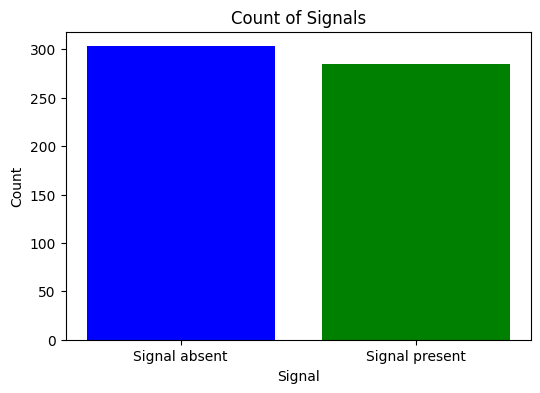

In [ ]:
import matplotlib.pyplot as plt

count_zeros = np.sum(all_labels == 0)
count_ones = np.sum(all_labels == 1)

labels = ['Signal absent', 'Signal present']
counts = [count_zeros, count_ones]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['blue', 'green'])
plt.xlabel('Signal')
plt.ylabel('Count')
plt.title('Count of Signals')

plt.show()

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.05, random_state=48)

# Asegurarse de que las imágenes tengan una única canal
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Construir el modelo CNN con regularización L2
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
epocas = 20
history = model.fit(X_train, y_train, epochs=epocas, validation_split=0.05, batch_size=32)

# Evaluar el modelo
model.evaluate(X_test, y_test)


Epoch 1/20
17/17 [==============================] - 18s 638ms/step - loss: 4.2450 - accuracy: 0.5302 - val_loss: 2.8013 - val_accuracy: 0.5357
Epoch 2/20
17/17 [==============================] - 4s 231ms/step - loss: 2.4943 - accuracy: 0.5321 - val_loss: 2.2115 - val_accuracy: 0.5000
Epoch 3/20
17/17 [==============================] - 4s 228ms/step - loss: 1.7714 - accuracy: 0.6283 - val_loss: 1.5285 - val_accuracy: 0.5000
Epoch 4/20
17/17 [==============================] - 4s 227ms/step - loss: 1.3580 - accuracy: 0.6264 - val_loss: 1.2266 - val_accuracy: 0.6786
Epoch 5/20
17/17 [==============================] - 4s 230ms/step - loss: 1.1133 - accuracy: 0.7019 - val_loss: 1.0829 - val_accuracy: 0.6429
Epoch 6/20
17/17 [==============================] - 4s 232ms/step - loss: 0.9837 - accuracy: 0.7811 - val_loss: 0.8869 - val_accuracy: 0.8571
Epoch 7/20
17/17 [==============================] - 4s 229ms/step - loss: 0.7919 - accuracy: 0.8566 - val_loss: 1.0396 - val_accuracy: 0.5000
Epoch

[0.35607805848121643, 1.0]

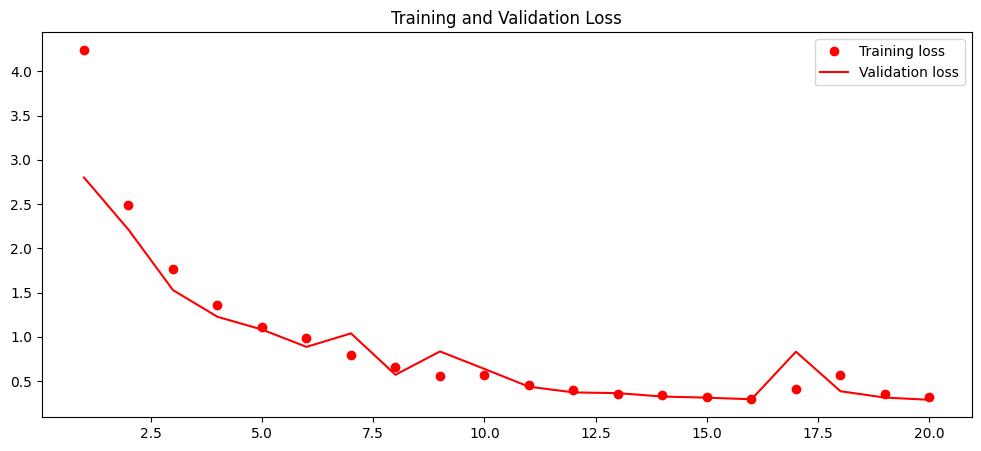

In [12]:
def plot_training_history(history, epocas):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, epocas + 1)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history, epocas)

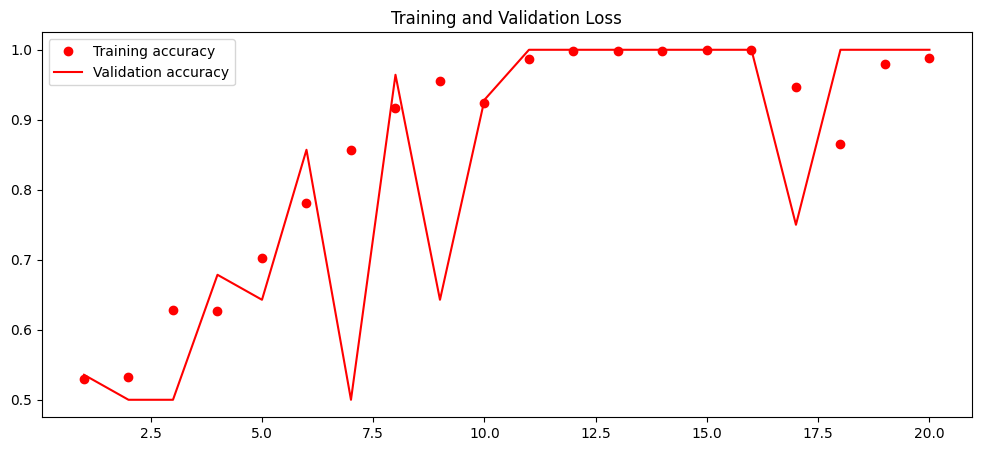

In [13]:
def plot_training_history(history, epocas):
    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(1, epocas + 1)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'ro', label='Training accuracy')
    plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history, epocas)

In [14]:
model.save(data_dir + '/modelcnn5.keras')

# Using Keras Tuner

In [2]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [3]:
from keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        input_shape=(474, 342, 1)
    ))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [4]:
import numpy as np
data_dir = "/content/drive/MyDrive/RDP"

all_images = np.load(data_dir + '/decimated_images.npy')
all_labels = np.load(data_dir + '/labels.npy')
all_images.shape, all_labels.shape

((588, 474, 342), (588,))

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import numpy as np

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.05, random_state=48)

# Asegurarse de que las imágenes tengan una única canal
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train.shape[1], X_train.shape[2]

(474, 342)

In [6]:
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=2,
    directory="/content/drive/MyDrive/RDP",
    project_name='challenge8'
)

Reloading Tuner from /content/drive/MyDrive/RDP/challenge8/tuner0.json


In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.05)

Trial 2 Complete [00h 00m 14s]

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 02m 37s


In [7]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
El tuner recomienda usar {best_hps.get('units')} unidades para la capa oculta
y una tasa de aprendizaje de {best_hps.get('learning_rate')}.
""")

model = tuner.hypermodel.build(best_hps)
epocas = 20
history = model.fit(X_train, y_train, epochs=epocas, validation_split = 0.1)


El tuner recomienda usar 64 unidades para la capa oculta
y una tasa de aprendizaje de 0.001.

Epoch 1/20
16/16 [==============================] - 12s 246ms/step - loss: 8.6134 - accuracy: 0.5498 - val_loss: 1.2597 - val_accuracy: 0.6429
Epoch 2/20
16/16 [==============================] - 2s 142ms/step - loss: 0.6013 - accuracy: 0.7430 - val_loss: 0.3032 - val_accuracy: 0.8571
Epoch 3/20
16/16 [==============================] - 2s 142ms/step - loss: 0.3932 - accuracy: 0.8048 - val_loss: 0.2609 - val_accuracy: 0.9107
Epoch 4/20
16/16 [==============================] - 3s 159ms/step - loss: 0.1615 - accuracy: 0.9721 - val_loss: 0.2559 - val_accuracy: 0.9107
Epoch 5/20
16/16 [==============================] - 3s 174ms/step - loss: 0.0625 - accuracy: 1.0000 - val_loss: 0.1459 - val_accuracy: 0.9821
Epoch 6/20
16/16 [==============================] - 2s 152ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.0978 - val_accuracy: 0.9821
Epoch 7/20
16/16 [==============================] - 

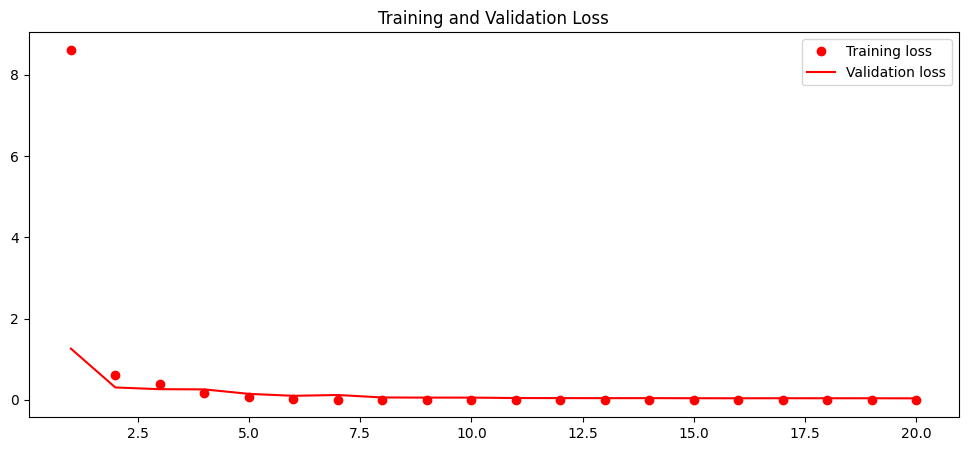

In [8]:
import matplotlib.pyplot as plt
def plot_training_history(history, epocas):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, epocas + 1)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history, epocas)

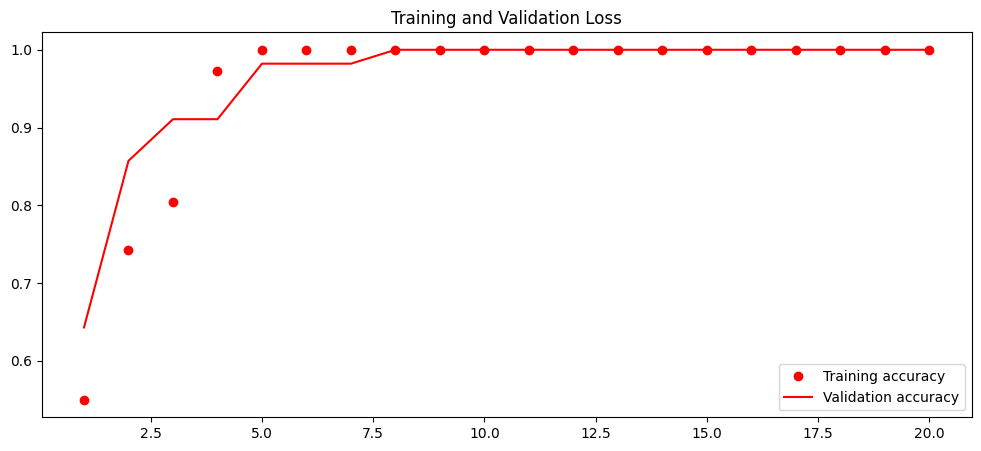

In [10]:
def plot_training_history(history, epocas):
    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(1, epocas + 1)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'ro', label='Training accuracy')
    plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history, epocas)